In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras import layers, callbacks

In [2]:
df = pd.read_csv('C:/Users/ArnabBiswas/Documents/Data/Kaggle Dataset/Mastercard_stock_history.csv')

In [7]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872 entries, 0 to 3871
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3872 non-null   object 
 1   Open          3872 non-null   float64
 2   High          3872 non-null   float64
 3   Low           3872 non-null   float64
 4   Close         3872 non-null   float64
 5   Volume        3872 non-null   int64  
 6   Dividends     3872 non-null   float64
 7   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 242.1+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03,3872.000000,3872.000000
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07,0.002329,0.002583
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07,0.025851,0.160706
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05,0.000000,0.000000
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06,0.000000,0.000000
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06,0.000000,0.000000
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07,0.000000,0.000000
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08,0.440000,10.000000


In [6]:
# Setting Datetime

df.index = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)

In [8]:
# Setting Training and test Data

train = df[(df.index.year<2021) & (df.index.year>=2016)]
test = df[df.index.year>=2021]

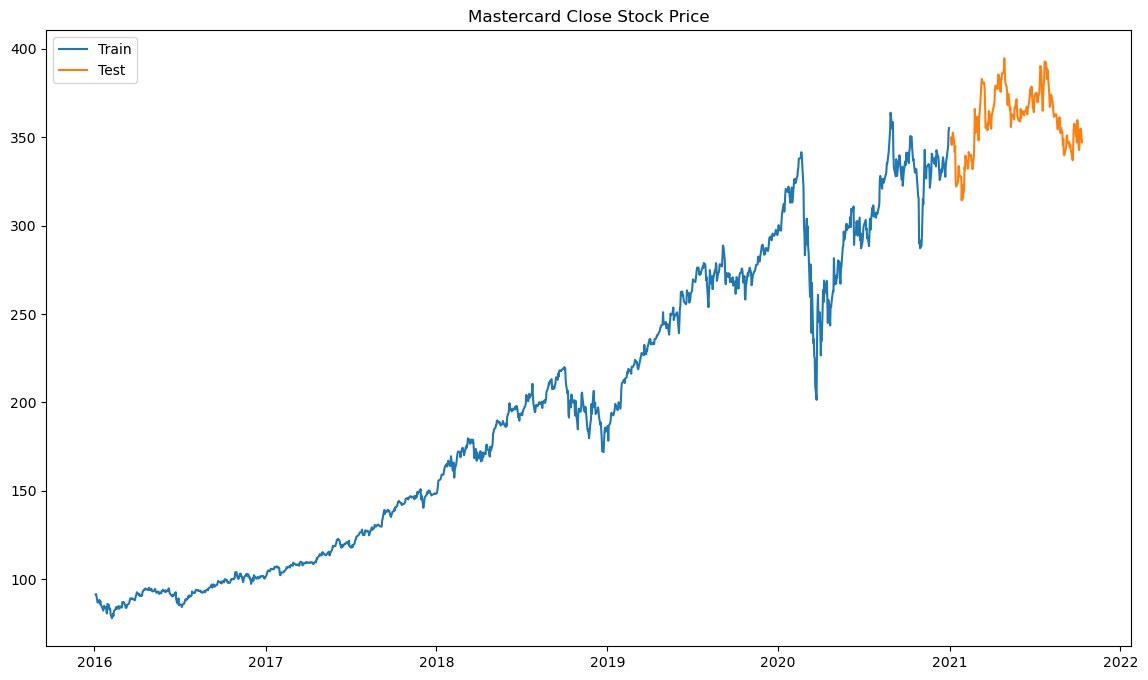

In [9]:
plt.figure(figsize=(14,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.legend()
plt.title('Mastercard Close Stock Price')
plt.show()

In [11]:
# We want to normalize the input data before feeding it to an LSTM model. Normalization helps to scale the data and make 
# it easier for the LSTM to learn. We will translate the featureb between zero and one.

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1, 1))

In [12]:
X_train = []
y_train = []
for i in range(80,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-80:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# Reshape to feed the LSTM model

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [14]:
# The model

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    layers.Dropout(0.2),
    
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),
    
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(units=50),
    layers.Dropout(0.2),
    
    layers.Dense(units=1),
])

model.compile(optimizer='adam',loss='mse', metrics=['mse', 'mae', 'mape'])

In [15]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 80, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 80, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 80, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [16]:
# Training

early_stopping = callbacks.EarlyStopping(
    patience=6,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(X_train,y_train,epochs=100,batch_size=24, callbacks=[early_stopping])

Epoch 1/100
50/50 [==============================] - 14s 98ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.0912 - mape: 31.6111
Epoch 2/100
50/50 [==============================] - 5s 99ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0493 - mape: 12.8771
Epoch 3/100
50/50 [==============================] - 5s 101ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0443 - mape: 11.4157
Epoch 4/100
50/50 [==============================] - 5s 108ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0477 - mape: 12.1140
Epoch 5/100
50/50 [==============================] - 7s 131ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0416 - mape: 11.2524
Epoch 6/100
50/50 [==============================] - 6s 122ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0384 - mape: 10.5435
Epoch 7/100
50/50 [==============================] - 6s 125ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0433 - mape: 12.2173
Epoch 8/100
50/50 [==============================] - 6s 123ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0414 - mape: 1

50/50 [==============================] - 7s 136ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0350 - mape: 10.0792
Epoch 24/100
50/50 [==============================] - 7s 130ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0369 - mape: 10.8637
Epoch 25/100
50/50 [==============================] - 6s 129ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0354 - mape: 10.5377
Epoch 26/100
50/50 [==============================] - 7s 137ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0348 - mape: 10.2900
Epoch 27/100
50/50 [==============================] - 6s 123ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0355 - mape: 11.1017
Epoch 28/100
50/50 [==============================] - 6s 126ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0399 - mape: 12.3880
Epoch 29/100
50/50 [==============================] - 6s 127ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0338 - mape: 10.7938
Epoch 30/100
50/50 [==============================] - 6s 124ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0311 - mape: 10.12

50/50 [==============================] - 6s 125ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0329 - mape: 11.9100
Epoch 47/100
50/50 [==============================] - 6s 120ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0299 - mape: 11.7833
Epoch 48/100
50/50 [==============================] - 6s 129ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0307 - mape: 11.6381
Epoch 49/100
50/50 [==============================] - 7s 130ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0298 - mape: 11.0872
Epoch 50/100
50/50 [==============================] - 7s 135ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0298 - mape: 10.3974
Epoch 51/100
50/50 [==============================] - 7s 141ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0299 - mape: 11.0710
Epoch 52/100
50/50 [==============================] - 7s 135ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0307 - mape: 11.5610
Epoch 53/100
50/50 [==============================] - 8s 167ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0289 - mape: 11.31

50/50 [==============================] - 7s 138ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0281 - mape: 11.7466
Epoch 69/100
50/50 [==============================] - 8s 153ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0288 - mape: 11.6035
Epoch 70/100
50/50 [==============================] - 6s 121ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0276 - mape: 11.7615
Epoch 71/100
50/50 [==============================] - 7s 134ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0272 - mape: 11.2256
Epoch 72/100
50/50 [==============================] - 6s 123ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0287 - mape: 13.8822
Epoch 73/100
50/50 [==============================] - 8s 161ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - mape: 11.9696
Epoch 74/100
50/50 [==============================] - 7s 147ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0285 - mape: 12.8003
Epoch 75/100
50/50 [==============================] - 7s 140ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0275 - mape: 11.11

50/50 [==============================] - 7s 149ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0273 - mape: 12.7477
Epoch 92/100
50/50 [==============================] - 8s 157ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0273 - mape: 13.7779
Epoch 93/100
50/50 [==============================] - 8s 156ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0265 - mape: 13.2083
Epoch 94/100
50/50 [==============================] - 6s 129ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0272 - mape: 12.6722
Epoch 95/100
50/50 [==============================] - 6s 128ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0256 - mape: 12.2041
Epoch 96/100
50/50 [==============================] - 6s 123ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0265 - mape: 11.8415
Epoch 97/100
50/50 [==============================] - 6s 119ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0266 - mape: 12.1594
Epoch 98/100
50/50 [==============================] - 6s 116ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0259 - mape: 12.39

### Validation - 
       Mean squared error (MSE) - the average squared difference between the predicted values and the actual values.
       Mean absolute error (MAE) - the average absolute difference between the predicted values and the actual values
       Mean absolute percentage error (MAPE) - calculates the percentage difference between the predicted values and the actual values, and then averages these percentage differences

In [17]:
history_frame = pd.DataFrame(history.history)

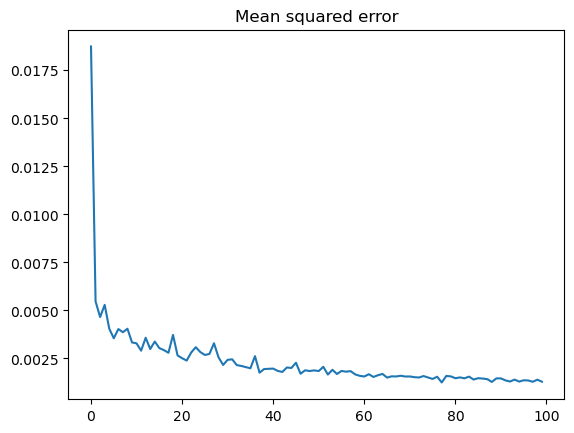

In [18]:
plt.plot(history_frame.loc[:, ['mse']])
plt.title('Mean squared error')
plt.show()

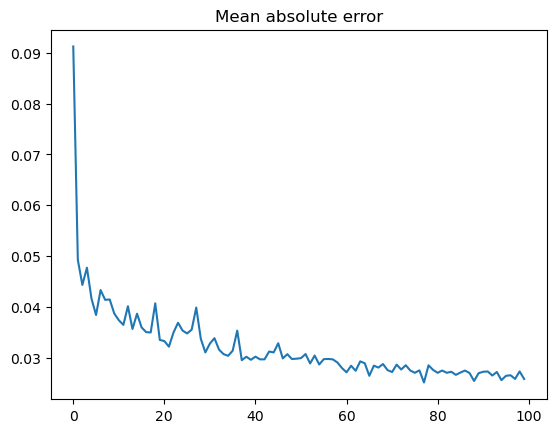

In [19]:
plt.plot(history_frame.loc[:, ['mae']])
plt.title('Mean absolute error')
plt.show()

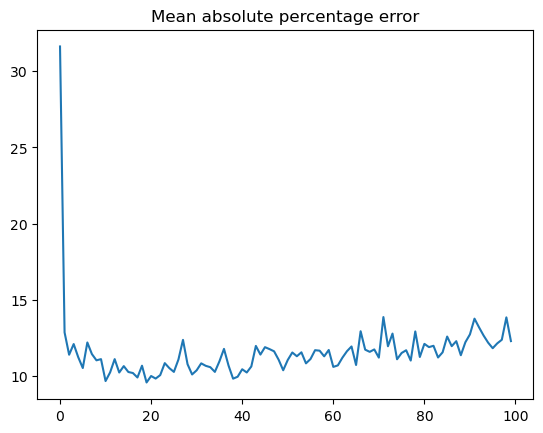

In [20]:
plt.plot(history_frame.loc[:, ['mape']])
plt.title('Mean absolute percentage error')
plt.show()

In [21]:
# Predictions

dataset_total = df['Close']
inputs = dataset_total[len(dataset_total)-len(test['Close'].values) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [22]:
X_test = []
for i in range(80,len(inputs)):
    X_test.append(inputs[i-80:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)

7/7 [==============================] - 2s 37ms/step


In [23]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [24]:
predictions = pd.DataFrame()
predictions['Actuals'] = test['Close']
predictions['Predictions'] = predicted_stock_price

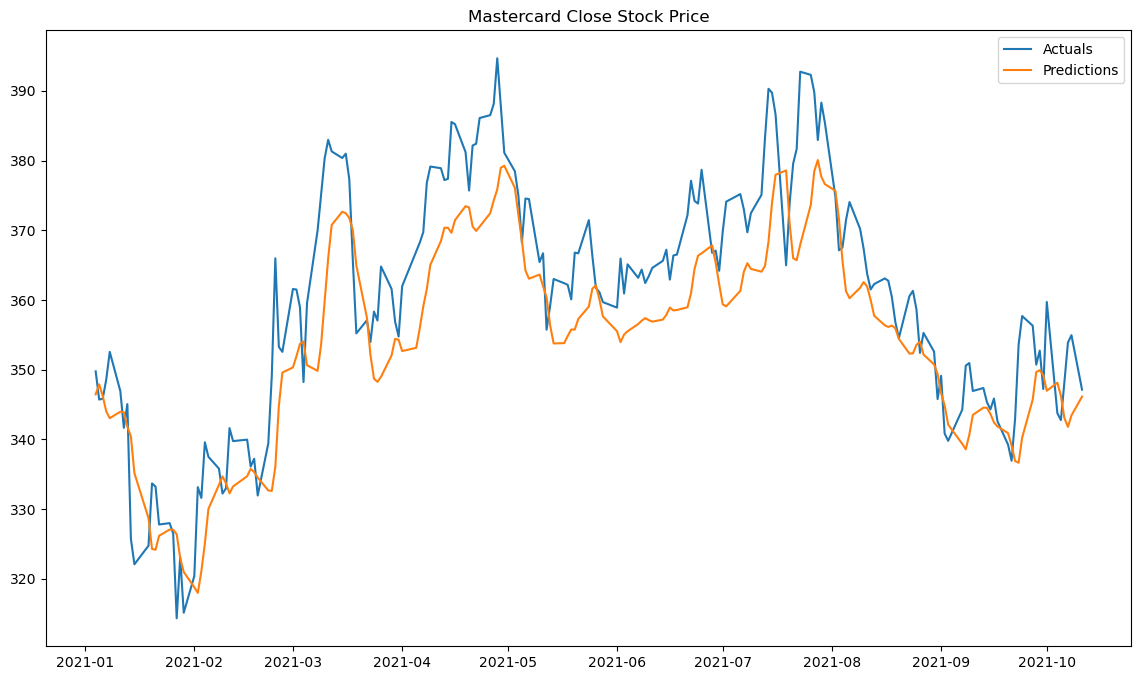

In [25]:
# Actual vs Prediction

plt.figure(figsize=(14,8))
plt.title('Mastercard Close Stock Price')
plt.plot(predictions['Actuals'], label='Actuals')
plt.plot(predictions['Predictions'], label='Predictions')
plt.legend()
plt.show()